# Tutorial on MORPH

In this tutorial, we will assess the performance of a facial recognition system in a 1:1 face
verification task on the [MORPH dataset](https://uncw.edu/oic/tech/morph.html). We have obtained the
embeddings generated by the system for the images in the data and stored them in a dictionary
`df[identity name][image name] = embedding`. Below we load the dictionary.


In [1]:
import json
from utils import *

df_main = json.load(open('../data/morph/embeddings.json', 'r'))
len(df_main)  # number of identities in the data


63548

We analyze the system performance in two settings:

- [_small datasets_](#computations-on-small-datasets): We assess the system performance on all pairwise comparisons between the images in the data.
- [_large datasets_](#computations-on-massive-datasets): We compute the system performance on a subset of all pairwise comparisons between the images in the data.

We compute confidence intervals for error metrics for a given score threshold as well as pointwise intervals for the ROC using the Wilson method, the double-or-nothing bootstrap, and the vertexex bootstrap.


## Computations on small datasets


Let's first look at how to construct confidence intervals for error rates on small datasets. here we consider only 50 IDs in the data and we compute the error metrics on this small dataset. 


In [2]:
# subset the IDs
df = {id: df_main[id] for id in list(df_main.keys())[:50]}
len(df)


50

In [3]:
# compute cosine similarity between IDs
df_sim = generate_similarity_scores(df, method = 'cosine')


We now show how to construct

- confidence intervals for error metrics that are computed by fixing the threshold used to turn scores into binary predictions.
- pointwise confidence intervals for the ROC.


### Confidence intervals for error metrics at a fixed threshold


In [4]:
threshold = 0.9 # set a threshold
df_error = generate_errors(df=df_sim, threshold=threshold) # generate dictionary with 0/1 outputs corresponding to accurate predictions/errors
fnmr, fmr = compute_error_metrics(df_error) # compute FNMR and FMR
print(fnmr, fmr)


0.1217985202048947 0.23590508200449825


In [5]:
# compute the intervals
# double-or-nothing bootstrap
fnmr_ci_dbn, fmr_ci_dbn = get_ci_boot(
    df=df_error, alpha=0.05, B=1000, method="dbn")

# vertexex bootstrap
fnmr_ci_vertex, fmr_ci_vertex = get_ci_boot(
    df=df_error, alpha=0.05, B=1000, method="vertex")

# wilson
fnmr_var, fmr_var = estimate_var_error_metrics(
    df_error)  # obtain variance of the error metrics
neg = sum([sum([len(df_error[id1][id2]) for id2 in df_error if id1 != id2])
          for id1 in df_error]) / 2  # total negatives
fmr_ci_wil = get_ci_wilson(
    n_errors=fmr * neg, n_instances=neg, mean_variance=fmr_var, alpha=0.05)
pos = sum([len(df_error[id][id])
          for id in df_error.keys() if id in df_error[id]])  # total positives
fnmr_ci_wil = get_ci_wilson(
    n_errors=fnmr * pos, n_instances=pos, mean_variance=fnmr_var, alpha=0.05)


In [6]:
# compare the intervals for FNMR and FMR
print(fnmr_ci_dbn, fmr_ci_dbn)
print(fnmr_ci_vertex, fmr_ci_vertex)
print(fnmr_ci_wil, fmr_ci_wil)


[0.07547169811320754, 0.25] [0.17159465653546616, 0.3079172981259001]
[0.0819044700708255, 0.22413843165525252] [0.1772974001807305, 0.3054201281992502]
[0.0755730441696184, 0.19047274972793066] [0.1849825124771934, 0.29575878950256124]


### Pointwise confidence intervals for the ROC


In [7]:
# intervals for FNMR @ FMR = 1e-4, 1e-3, 1e-2, 1e-2, 1
target_fmr = [0.0001, 0.001, 0.01, 0.1, 1]

# Wilson
ci_roc_wilson = get_ci_roc_wilson(
    df=df_sim, alpha=0.05, target_fpr=target_fmr, alpha_fpr=0.1)

# bootstraps
ci_roc_vertex = get_ci_roc_boot(df=df_sim, alpha=0.05, B=1000, target_fpr=target_fmr,
                                method="vertex", parallel=True)
ci_roc_dbn = get_ci_roc_boot(df=df_sim, alpha=0.05,
                             B=1000, target_fpr=target_fmr, method="dbn", parallel=True)


In [8]:
for fpr in target_fmr:
    print('---', fpr)
    print(fpr, 1 - ci_roc_wilson['tpr'][ci_roc_wilson['fpr'].index(
        fpr)], [1 - x for x in ci_roc_wilson['tpr_cis'][ci_roc_wilson['fpr'].index(fpr)]][::-1])
    print(fpr, 1 - ci_roc_vertex['tpr'][ci_roc_vertex['fpr'].index(
        fpr)], [1 - x for x in ci_roc_vertex['tpr_cis'][ci_roc_vertex['fpr'].index(fpr)]][::-1])
    print(fpr, 1 - ci_roc_dbn['tpr'][ci_roc_dbn['fpr'].index(
        fpr)], [1 - x for x in ci_roc_dbn['tpr_cis'][ci_roc_dbn['fpr'].index(fpr)]][::-1])

--- 0.0001
0.0001 0.7803073420603301 [0.4283051832453819, 0.9585427427481849]
0.0001 0.7803073420603301 [0.4468066878131207, 0.9420627831069529]
0.0001 0.7803073420603301 [0.4206323992614316, 0.9511646770600001]
--- 0.001
0.001 0.4462151394422311 [0.27620411346921636, 0.6597148212255567]
0.001 0.4462151394422311 [0.29783436108955774, 0.6729064223030952]
0.001 0.4462151394422311 [0.28442893647861833, 0.703150425295858]
--- 0.01
0.01 0.23733636881047238 [0.14604032606434036, 0.3498008496238645]
0.01 0.23733636881047238 [0.16030682768367854, 0.38075124993081566]
0.01 0.23733636881047238 [0.15733053169780542, 0.4075239580164284]
--- 0.1
0.1 0.15822424587364825 [0.0933782903039817, 0.2505828815149107]
0.1 0.15822424587364825 [0.10462973719833746, 0.2857177700348432]
0.1 0.15822424587364825 [0.1002798122875509, 0.30898056891961323]
--- 1
1 0.0 [0.0, 0.002181604028830053]
1 0.0 [0.0, 0.002181604028829942]
1 0.0 [0.0, 0.002181604028829942]


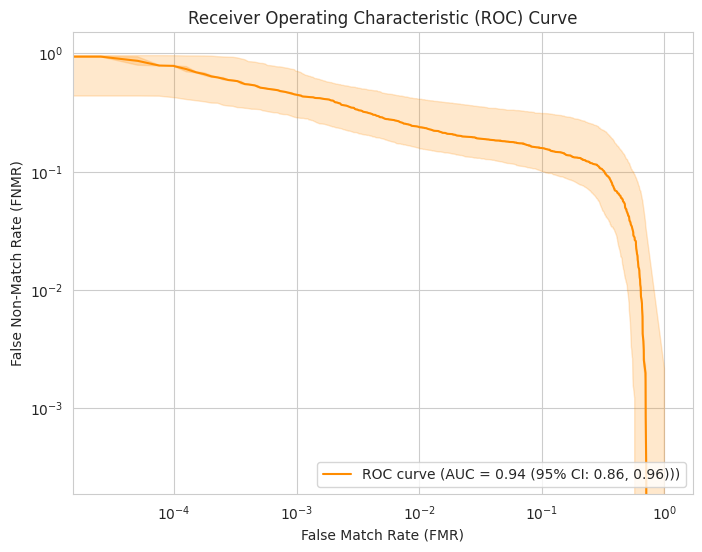

In [9]:
# plot the ROC curve with the double-or-nothing bootstrap intervals
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

intervals = ci_roc_dbn

sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
sns.lineplot(x='fmr', y='fnmr', data=pd.DataFrame(
    {'fmr': intervals['fpr'], 'fnmr': [1 - x for x in intervals['tpr']]}), color='darkorange', label=f'ROC curve (AUC = {intervals["auc"]:.2f} (95% CI: {intervals["auc_cis"][0]:.2f}, {intervals["auc_cis"][1]:.2f})))')
plt.fill_between(intervals['fpr'], [1 - x[1] for x in intervals['tpr_cis']],
                 [1 - x[0] for x in intervals['tpr_cis']], alpha=0.2, color='darkorange', label='')
plt.xlabel('False Match Rate (FMR)')
plt.ylabel('False Non-Match Rate (FNMR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.xscale('log')
plt.yscale('log')
plt.show()


## Computations on massive datasets


In [10]:
# load the dataset again
df = df_main


In [11]:
# how many observations are there in the dataset?
# total observations for fnmr computations
print(sum([len(df[id]) * (len(df[id]) - 1) / 2 for id in df]))
# m_by_id = [len(df[id]) for id in df] # total observations for fmr computations
# print(sum([m_by_id[i] * sum([m_by_id[j] for j in range(len(m_by_id)) if j != i]) for i in range(len(m_by_id))]) / 2)


3001005.0


We first set a budget, that is we decide the maximum number of pairwise comparisons that we can take into account in the computations of error metrics and confidence intervals given our computational resources. We will randomly pick the combinations of identities and corresponding images to be used.  

In [12]:
def pick_random_combs(df, budget_fnmr, budget_fmr):
    identities = list(df.keys())

    # not sampling from the full list of (identity, image) pairs because the number is too large
    # if dataset is very imbalanced, sampling from the full list (or as below but with weights proportional to the number of images per identity) is better to avoid picking the same identities with few images over and over again
    combs_fmr = set()
    while budget_fmr > 0:
        idc1, idc2 = random.sample(identities, k=2)
        imgc1, imgc2 = random.sample(list(df[idc1]), k=1)[
            0], random.sample(list(df[idc2]), k=1)[0]
        if (idc1, imgc1, idc2, imgc2) not in combs_fmr and (idc1, imgc1, idc2, imgc2) not in combs_fmr and idc1 != idc2:
            combs_fmr.add((idc1, imgc1, idc2, imgc2))
            budget_fmr -= 1

    combs_fnmr = set()
    while budget_fnmr > 0:
        idc1 = random.sample(identities, k=1)[0]
        imgs = list(df[idc1])
        if len(imgs) > 2:
            imgc1, imgc2 = random.sample(imgs, k=2)

            if (idc1, imgc1, idc1, imgc2) not in combs_fnmr and (idc1, imgc1, idc1, imgc2) not in combs_fnmr:
                combs_fnmr.add((idc1, imgc1, idc1, imgc2))
                budget_fnmr -= 1

    return combs_fnmr, combs_fmr

budget = 1e5
fnmr_pairs, fmr_pairs = pick_random_combs(df, budget, budget)
combs = set(fnmr_pairs).union(fmr_pairs)


In [13]:
# compute distances for the pairs in the protocols
df_sim = generate_similarity_scores(df, pairs = combs, method = 'cosine')


In [14]:
threshold = 0.8
df_error = generate_errors(df=df_sim, threshold=threshold)
fnmr, fmr = compute_error_metrics(df_error)
print(fnmr, fmr)  # erorr metrics for the pairs in the protocols


0.00015 0.94427


### Confidence intervals for error metrics at a fixed threshold

We now compute Wilson and bootstrap confidence intervals.


In [15]:
# wilson
fnmr_var, fmr_var = estimate_var_error_metrics(df_error)
neg = sum([sum([len(df_error[id1][id2])
          for id2 in df_error[id1] if id1 != id2]) for id1 in df_error]) / 2  # total negatives
fmr_ci_wil = get_ci_wilson(
    n_errors=fmr * neg, n_instances=neg, mean_variance=fmr_var, alpha=0.05)
pos = sum([len(df_error[id][id])
          for id in df_error.keys() if id in df_error[id]])  # total positives
fnmr_ci_wil = get_ci_wilson(
    n_errors=fnmr * pos, n_instances=pos, mean_variance=fnmr_var, alpha=0.05)


In [16]:
# double-or-nothing bootstrap
fnmr_ci_dbn, fmr_ci_dbn = get_ci_boot(
    df=df_error, alpha=0.05, B=1000, parallel=True, method = "dbn")


In [17]:
# vertex bootstrap
fnmr_ci_vertex, fmr_ci_vertex = get_ci_boot(
    df=df_error, alpha=0.05, B=1000, parallel=True, method = "vertex")


In [18]:
print(fnmr_ci_wil, fmr_ci_wil)
print(fnmr_ci_dbn, fmr_ci_dbn)
print(fnmr_ci_vertex, fmr_ci_vertex)


[9.091493259516554e-05, 0.0002474745933832967] [0.9426116851248723, 0.9458831466935158]
[7.967913228590061e-05, 0.00022113708693570174] [0.9416970446497164, 0.9467886604458758]
[7.993216224735454e-05, 0.0002206881083210026] [0.9430429099631702, 0.9455753955426391]


### Pointwise confidence intervals for the ROC


In [19]:
# intervals for FNMR @ FMR at different values
target_fmr = [1e-4, 1e-3, 1e-2, 1e-2, 1e-1, 1]
ci_roc_wil = get_ci_roc_wilson(
    df=df_sim, alpha=0.05, target_fpr=target_fmr, alpha_fpr=0.1, parallel=True)


In [20]:
ci_roc_vertex = get_ci_roc_boot(
    df=df_sim, alpha=0.05, B=1000, target_fpr=target_fmr, parallel=True, method = "vertex")


In [21]:
ci_roc_dbn = get_ci_roc_boot(
    df=df_sim, alpha=0.05, B=1000, target_fpr=target_fmr, parallel=True, method = "dbn")


In [22]:
for fpr in target_fmr:
    print('---', fpr)
    print(fpr, 1 - ci_roc_wilson['tpr'][ci_roc_wilson['fpr'].index(
        fpr)], [1 - x for x in ci_roc_wilson['tpr_cis'][ci_roc_wilson['fpr'].index(fpr)]][::-1])
    print(fpr, 1 - ci_roc_vertex['tpr'][ci_roc_vertex['fpr'].index(
        fpr)], [1 - x for x in ci_roc_vertex['tpr_cis'][ci_roc_vertex['fpr'].index(fpr)]][::-1])
    print(fpr, 1 - ci_roc_dbn['tpr'][ci_roc_dbn['fpr'].index(
        fpr)], [1 - x for x in ci_roc_dbn['tpr_cis'][ci_roc_dbn['fpr'].index(fpr)]][::-1])


--- 0.0001
0.0001 0.7803073420603301 [0.4283051832453819, 0.9585427427481849]
0.0001 0.8088 [0.7455252283414417, 0.8770546086158706]
0.0001 0.8088 [0.7388025181465985, 0.8763174162448291]
--- 0.001
0.001 0.4462151394422311 [0.27620411346921636, 0.6597148212255567]
0.001 0.6073200000000001 [0.5742817596499311, 0.6395171829548133]
0.001 0.6073200000000001 [0.5731769621246854, 0.6378527178646725]
--- 0.01
0.01 0.23733636881047238 [0.14604032606434036, 0.3498008496238645]
0.01 0.3467 [0.33594378451569873, 0.35684378239369896]
0.01 0.3467 [0.3353782563197667, 0.3564508703478192]
--- 0.01
0.01 0.23733636881047238 [0.14604032606434036, 0.3498008496238645]
0.01 0.3467 [0.33594378451569873, 0.35684378239369896]
0.01 0.3467 [0.3353782563197667, 0.3564508703478192]
--- 0.1
0.1 0.15822424587364825 [0.0933782903039817, 0.2505828815149107]
0.1 0.22209999999999996 [0.21820618544601678, 0.225706444918521]
0.1 0.22209999999999996 [0.2182861246844, 0.22591875376329873]
--- 1
1 0.0 [0.0, 0.00218160402883